# LightAutoML: Interpretation Tutorial

Some of HTML static content is not loading, to solve this problem you can use [nbviewer](https://nbviewer.jupyter.org). Link on tutorial on nbviever [here](https://nbviewer.jupyter.org/github/sberbank-ai-lab/LightAutoML/blob/pooling_fix/Tutorial_5.%20NLP%20Interpretation.ipynb).

The last years deep neural networks / gradient boosting / ensembles of models allow to improve the soulution quality of many application task in field of natural language processing (NLP). The indicators of this improvement describe the partial behavior of the model and can hide errors, for example, errors in the construction of the model, errors in data collection. All this can be critical in tasks related to the processing of medical, forensic, banking data.
In this tutorial we will check the NLP interpetation module of automl.

## Download library and make some imports

In [1]:
# !pip install lightautoml

In [2]:
import shutil

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import LimeTextExplainer, L2XTextExplainer

import transformers
transformers.logging.set_verbosity(50)

import pickle

## Dowload data

For this tutorial we will use train dataset (train.csv) from [Jigsaw-Toxic-Comment-Classification-Challage](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview). The dataset contains  textual comments and 6 attributes of this text (toxic, serve_toxic, obscene, treat, insult, identity_hate). For now, we will use only <i>toxic</i> attribute.

In [3]:
# train.csv file from
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

data = pd.read_csv('train.csv')
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Usage of AutoML 

We will use standard ``lightautoml.automl.presets.text_presets.TabularNLPAutoML`` preset with finetuned TinyBERT from [Hugging Face](https://huggingface.co).

In [4]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'], 
    'drop': ['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    'target': 'toxic'
}

task = Task('binary')

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    },
    verbose=2
)

oof_pred = automl.fit_predict(train, roles=roles)
test_pred = automl.predict(test)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred.data[:, 0])))

Model language mode: en
Start automl preset with listed constraints:
- time: 3600 seconds
- cpus: 1 cores
- memory: 16 gb

Train data shape: (127656, 8)


Layer 1 ...
Train process start. Time left 3599.8790543079376 secs
Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.30it/s]

Epoch: 0, train loss: 0.2570450007915497, val loss: 0.19485096633434296, val metric: 0.9637836876016782



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.33it/s]

Epoch: 1, train loss: 0.16872628033161163, val loss: 0.14495356380939484, val metric: 0.9713542494872768



val: 100%|██████████| 1330/1330 [01:06<00:00, 19.93it/s]

Epoch: 2, train loss: 0.13151153922080994, val loss: 0.12280727922916412, val metric: 0.9747751993810625



val: 100%|██████████| 1330/1330 [01:06<00:00, 20.14it/s]

Epoch: 3, train loss: 0.11367320269346237, val loss: 0.1126171126961708, val metric: 0.9765513956674373



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.20it/s]

Epoch: 4, train loss: 0.1027149185538292, val loss: 0.10632816702127457, val metric: 0.977796992159309



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.18it/s]

Epoch: 5, train loss: 0.09626304358243942, val loss: 0.10376758873462677, val metric: 0.9785787008580725



val: 100%|██████████| 1330/1330 [01:06<00:00, 20.11it/s]

Epoch: 6, train loss: 0.09030253440141678, val loss: 0.1034480407834053, val metric: 0.9788737906916769



===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 1330/1330 [01:06<00:00, 20.04it/s]

Epoch: 0, train loss: 0.25809404253959656, val loss: 0.19568908214569092, val metric: 0.9628246754519126



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.82it/s]

Epoch: 1, train loss: 0.17004330456256866, val loss: 0.1436380296945572, val metric: 0.9712892929811795



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.83it/s]

Epoch: 2, train loss: 0.1328740119934082, val loss: 0.1212274506688118, val metric: 0.9752712916851096



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.78it/s]

Epoch: 3, train loss: 0.11425625532865524, val loss: 0.11091475933790207, val metric: 0.9771619079823601



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.65it/s]

Epoch: 4, train loss: 0.10420488566160202, val loss: 0.10691312700510025, val metric: 0.9783463079117893



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.77it/s]

Epoch: 5, train loss: 0.09668266773223877, val loss: 0.10273038595914841, val metric: 0.978979559261725



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.66it/s]

Epoch: 6, train loss: 0.09077204763889313, val loss: 0.10302633047103882, val metric: 0.9793691977461714



val: 100%|██████████| 1330/1330 [01:06<00:00, 19.99it/s]

Early stopping: val loss: 0.10273038595914841, val metric: 0.978979559261725



===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.25it/s]


Epoch: 0, train loss: 0.2581411302089691, val loss: 0.19450736045837402, val metric: 0.9639252648579809


val: 100%|██████████| 1330/1330 [01:06<00:00, 20.06it/s]

Epoch: 1, train loss: 0.1706278920173645, val loss: 0.1428082436323166, val metric: 0.970978252550365



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.27it/s]


Epoch: 2, train loss: 0.13274139165878296, val loss: 0.1216595396399498, val metric: 0.9745216901092819


val: 100%|██████████| 1330/1330 [01:05<00:00, 20.31it/s]


Epoch: 3, train loss: 0.1141367182135582, val loss: 0.11119359731674194, val metric: 0.9764433868724282


val: 100%|██████████| 1330/1330 [01:05<00:00, 20.20it/s]


Epoch: 4, train loss: 0.10428732633590698, val loss: 0.1062881276011467, val metric: 0.9774170386217307


val: 100%|██████████| 1330/1330 [01:06<00:00, 19.96it/s]


Epoch: 5, train loss: 0.09581169486045837, val loss: 0.1043882891535759, val metric: 0.977735719335192


val: 100%|██████████| 1330/1330 [01:05<00:00, 20.24it/s]


Epoch: 6, train loss: 0.09032654762268066, val loss: 0.10361003130674362, val metric: 0.9784727676526263
Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
Time left -648.1437613964081


Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings



Automl preset training completed in 4248.15 seconds.


test: 100%|██████████| 998/998 [00:48<00:00, 20.41it/s]


Check scores:
OOF score: 0.977819000722559
TEST score: 0.9807768133435921


In [5]:
automl.set_verbosity_level(0) # refuse logging in automl

## LIME

Linear approximation of model nearby selected object. The weights of this linear model is feature attribution for automl's prediction for this object.

Algorithm:

0. Select object to interpret.

1. Select the input text column, that will be explained (```perturb_column```). All other columns of object will be fixed.

2. A dataset of size ```n_sample``` (by default ``5000``) is created by randomly deleting tokens (in groups). Dataset is binary (there is a token if one and no token if zero).

3. Predict with AutoML module target values for created dataset.

4. Optionally, the selection of features (important tokens) is performed using LASSO (```feature_selection='lasso'```, you can also ```'none'``` to not select and get them all). The number of features used after feature selection is ```n_feautres``` (```= 10``` by default).

5. We train the explained model on this (a linear model with weights, the method of calculating weights is the cosine distance by default, you can also use your own function or the name of the distance from ```sklearn.metrics.pairwise_distances```).

6. The weights of the linear model are the interpretation.

P.S. Care about the sentence length. Detokenization works within $O(n^2)$, where $n$ -- sentence length. 


Scheme of work:

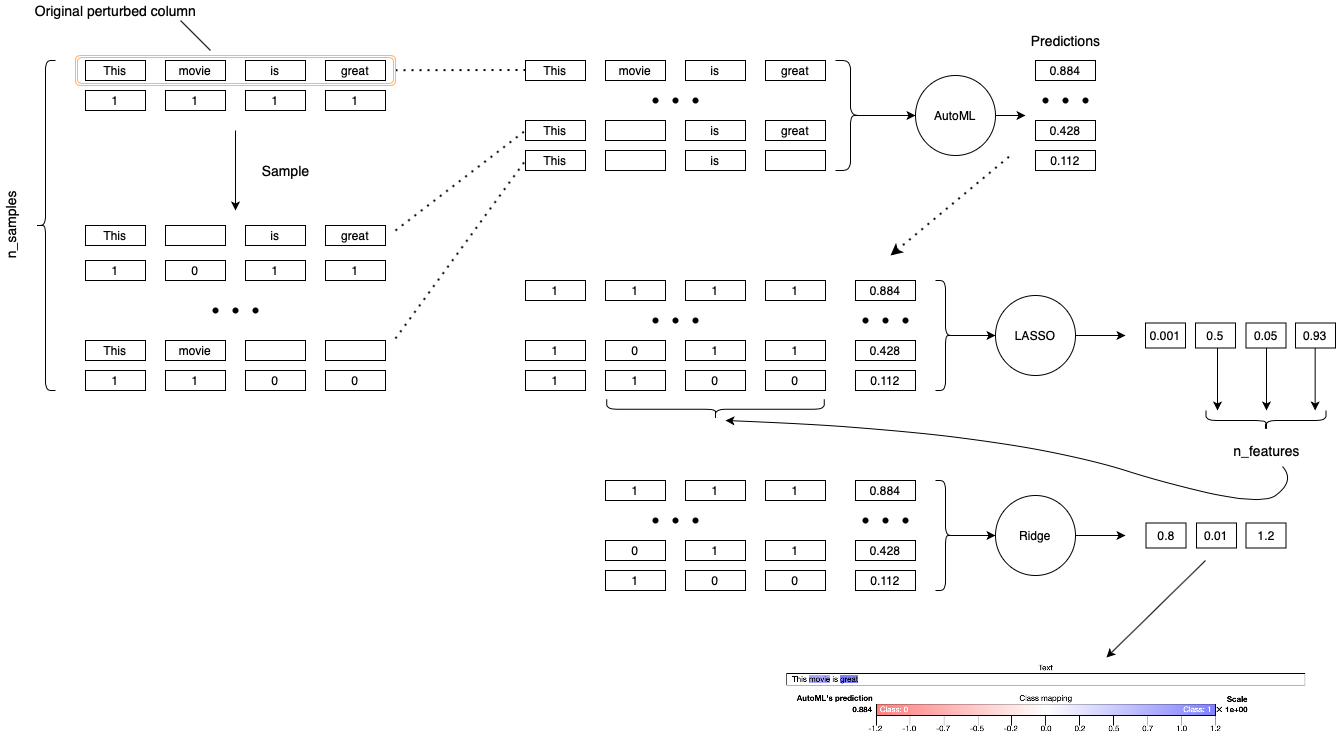

In [6]:
# LimeTextExplainer for NLP preset
lime = LimeTextExplainer(automl, feature_selection='lasso', force_order=False)

#### Let's try it on neutral text

In [7]:
exp = lime.explain_instance(test.loc[34019], labels=(0, 1), perturb_column='comment_text')
exp.visualize_in_notebook(1)

Text
 
 
 The lyrics is found in the German version , so I assume it ' s usable . ~ 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -7.3 -5.9 -4.4 -2.9 -1.5 0.0 1.5 2.9 4.4 5.9 7.3 
 

 Scale 
 ✕ 1e-05 

 AutoML's prediction 
 0.003

#### Toxic comments

In [8]:
exp = lime.explain_instance(test.loc[78687], labels=(0, 1), perturb_column='comment_text')
exp.visualize_in_notebook(1)

Text
 
 
 A silly fat cow who won ' t leave me alone 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.2 -1.7 -1.3 -0.9 -0.4 0.0 0.4 0.9 1.3 1.7 2.2 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.908

#### Let's see on uncertain expamples

In [9]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Why are you still here ? Can you not find anything more important to do , like killing yourself ? 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.2 -0.9 -0.7 -0.5 -0.2 0.0 0.2 0.5 0.7 0.9 1.2 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.082

Let's delete 'important' from this abstract. We can see that automl increase it's probability of toxicity of this abstract

In [10]:
test.loc[4733, 'comment_text'] = 'Why are you still here ? Can you not find anything more to do , like killing yourself ?'

In [11]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Why are you still here ? Can you not find anything more to do , like killing yourself ? 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.1 -1.7 -1.2 -0.8 -0.4 0.0 0.4 0.8 1.2 1.7 2.1 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.277

If we add the 'relability' the AutoML decrease the toxicity probability.

In [12]:
test.loc[4733, 'comment_text'] = 'Why are you still here ? Can you not find anything more to do , like killing yourself ? relability'

In [13]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Why are you still here ? Can you not find anything more to do , like killing yourself ? relability 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.9 -1.5 -1.1 -0.7 -0.4 0.0 0.4 0.7 1.1 1.5 1.9 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.217

Another example

In [14]:
exp = lime.explain_instance(test.loc[40112], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 stop editing this , you dumbass . why do you have to be such a bitch ? the ghosts of bill maas ' past will haunt you forever !!! MWAHAHHAHAA 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.7 -2.2 -1.6 -1.1 -0.5 0.0 0.5 1.1 1.6 2.2 2.7 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.918

Let's delete the toxic words to 'good boy'

In [15]:
test.loc[40112, 'comment_text'] = "stop editing this, you good boy. why do you have to be such a good boy? the ghosts of bill maas' past will haunt you forever!!! MWAHAHHAHAA"

In [16]:
exp = lime.explain_instance(test.loc[40112], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 stop editing this , you good boy . why do you have to be such a good boy ? the ghosts of bill maas ' past will haunt you forever !!! MWAHAHHAHAA 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.5 -1.2 -0.9 -0.6 -0.3 0.0 0.3 0.6 0.9 1.2 1.5 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.164

Let's try from neutral make toxic abstract.

In [17]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.2 -1.0 -0.7 -0.5 -0.2 0.0 0.2 0.5 0.7 1.0 1.2 
 

 Scale 
 ✕ 1e-03 

 AutoML's prediction 
 0.003

In [18]:
test.loc[18396] = "Okay , thanks . I will do so . dumbass please"

In [19]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -8.3 -6.6 -5.0 -3.3 -1.7 0.0 1.7 3.3 5.0 6.6 8.3 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.788

Adding some happy words

In [20]:
test.loc[18396] = "Okay , thanks . I will do so . happy dumbass please"

In [21]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . happy dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -7.6 -6.1 -4.6 -3.1 -1.5 0.0 1.5 3.1 4.6 6.1 7.6 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.652

More happy words.

In [22]:
test.loc[18396] = "Okay , thanks . I will do so . happy cheerful joyfull glorious elated dumbass please"

In [23]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . happy cheerful joyfull glorious elated dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -5.9 -4.7 -3.5 -2.3 -1.2 0.0 1.2 2.3 3.5 4.7 5.9 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.325

## L2X for Regression

For this part the [BeerAdvocate](http://people.csail.mit.edu/taolei/beer/) we will use. The dataset contains the reviews on alcoholic drinks (texutal comment + 5 attributes: overview, taste, plate, aroma, appearance). For this experiment we will use only ``appearance`` attribute.

In [24]:
def download_from_gdrive(file_id, file_name, chunk_size=2**15):
    import requests
    
    def handle_warning(res):
        for k, v in res.cookies.items():
            if k.startswith("download_warning"):
                return v
            
    template_url = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    res = session.get(template_url, params={"id": file_id}, stream=True)
    print('GET: {} CODE'.format(res.status_code))
    token = handle_warning(res)
    if token:
        res = session.get(template_url, params={"id": file_id, "confirm": token}, stream=True)
    print('Started downloading...')
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            if chunk:
                f.write(chunk)
    print('Downloaded.')

    
download_from_gdrive('1s8PG13Y0BvYM67nNL0EQpdgB5S4gJK9r', 'beeradvocate.tar.gz')
shutil.unpack_archive('beeradvocate.tar.gz', '.')

GET: 200 CODE
Started downloading...
Downloaded.


In [25]:
train_data = pd.read_csv('./datasets/reviews.aspect0.train.csv')
valid_data = pd.read_csv('./datasets/reviews.aspect0.heldout.csv')

train_data.head()

,Appearance,Aroma,Palate,Taste,Overall,Review,tokens_number
0,1.5,1.5,2.5,1.5,1.5,the main problem with this beer is that it has...,62
1,2.0,2.0,3.0,2.0,3.0,it is very unfortunate this situation we have ...,179
2,4.0,2.5,3.0,1.5,2.0,appearance is a light golden yellow with a thi...,79
3,4.5,3.5,2.0,3.5,3.0,it has a great color to the body . this beer p...,87
4,4.0,4.5,1.0,1.5,1.0,"though this beer is , or course , not carbonat...",246


In [26]:
roles = {
    'text': ['Review'], 
    'drop': ['tokens_number', 'Aroma', 'Palete', 'Taste', 'Overall'],
    'target': 'Appearance'
}

task = Task('reg')

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='1',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']],
        'n_folds': 3
    },
    reader_params={
        'cv': 3
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'bert-base-uncased'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    },
    verbose=2
)

oof_pred = automl.fit_predict(train_data, roles=roles)
test_pred = automl.predict(valid_data)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print('Check scores:')
print('OOF score: {}'.format(mean_squared_error(train_data[roles['target']].values[not_nan], oof_pred.data[not_nan][:, 0])))
print('TEST score: {}'.format(mean_squared_error(valid_data[roles['target']].values, test_pred.data[:, 0])))

Model language mode: en
Start automl preset with listed constraints:
- time: 3600 seconds
- cpus: 1 cores
- memory: 16 gb

Train data shape: (80000, 7)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3599.7471046447754 secs
Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 834/834 [02:20<00:00,  5.94it/s]


Epoch: 0, train loss: 0.7532112002372742, val loss: 0.5106852054595947, val metric: -0.5107554793357849


val: 100%|██████████| 834/834 [02:20<00:00,  5.92it/s]


Epoch: 1, train loss: 0.44464731216430664, val loss: 0.47099629044532776, val metric: -0.4710288643836975


val: 100%|██████████| 834/834 [02:21<00:00,  5.89it/s]

Epoch: 2, train loss: 0.34587690234184265, val loss: 0.47102463245391846, val metric: -0.4711504578590393



val: 100%|██████████| 834/834 [02:21<00:00,  5.91it/s]

Early stopping: val loss: 0.47099629044532776, val metric: -0.4710288643836975



===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 834/834 [02:05<00:00,  6.66it/s]


Epoch: 0, train loss: 0.7625529766082764, val loss: 0.5148500800132751, val metric: -0.5147587656974792


val: 100%|██████████| 834/834 [02:04<00:00,  6.68it/s]


Epoch: 1, train loss: 0.4452531039714813, val loss: 0.47788354754447937, val metric: -0.4777770936489105


val: 100%|██████████| 834/834 [02:04<00:00,  6.68it/s]


Epoch: 2, train loss: 0.3478119969367981, val loss: 0.46817511320114136, val metric: -0.4682581126689911


val: 100%|██████████| 834/834 [02:05<00:00,  6.65it/s]

Epoch: 3, train loss: 0.27783674001693726, val loss: 0.48863378167152405, val metric: -0.4883546829223633



val: 100%|██████████| 834/834 [02:05<00:00,  6.66it/s]

Early stopping: val loss: 0.46817511320114136, val metric: -0.4682581126689911



Time limit exceeded after calculating fold 1


Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
Time left -589.221994638443


Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings



Automl preset training completed in 4189.22 seconds.


test: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Check scores:
OOF score: 0.4696435024532692
TEST score: 0.43195273986092014


In [27]:
# >>> about 2gb
with open('apperance_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [28]:
with open('apperance_model.pkl', 'rb') as f:
    automl = pickle.load(f)
automl.set_verbosity_level(2)

## L2X

Algorithm.

0. The general idea of method is find the most informative subset of tokens with respect to target using [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information). The number of tokens in this subset is fixed and equals ```n_important```.

1. There is may be some missunderstanding with tokenization that used inside models in automl and tokenization in this method. L2X has its own tokenization, so they are different. If it isn't set we infer it from default tokenization for language in ``text_params`` of ```TabularNLPAutoML```. Else you can set it with language: ``'ru'`` or ``'en'`` for russian and english languages, respectively. Also it can be scepcified as callable function that from string produces list of tokens.

2. After tokenization sentence was presented as the matrix of embedding vectors (you can specify ``embedder``  or randomly initalized embeddings will be used). Not important vectors of this matrix will be masked (important tokens selected with Token Importance + Subset Sampler blocks), and the other use for model (Distil model), that tries to imitate the original automl model (learns to predict the same outputs).

3. Scheme of L2X:

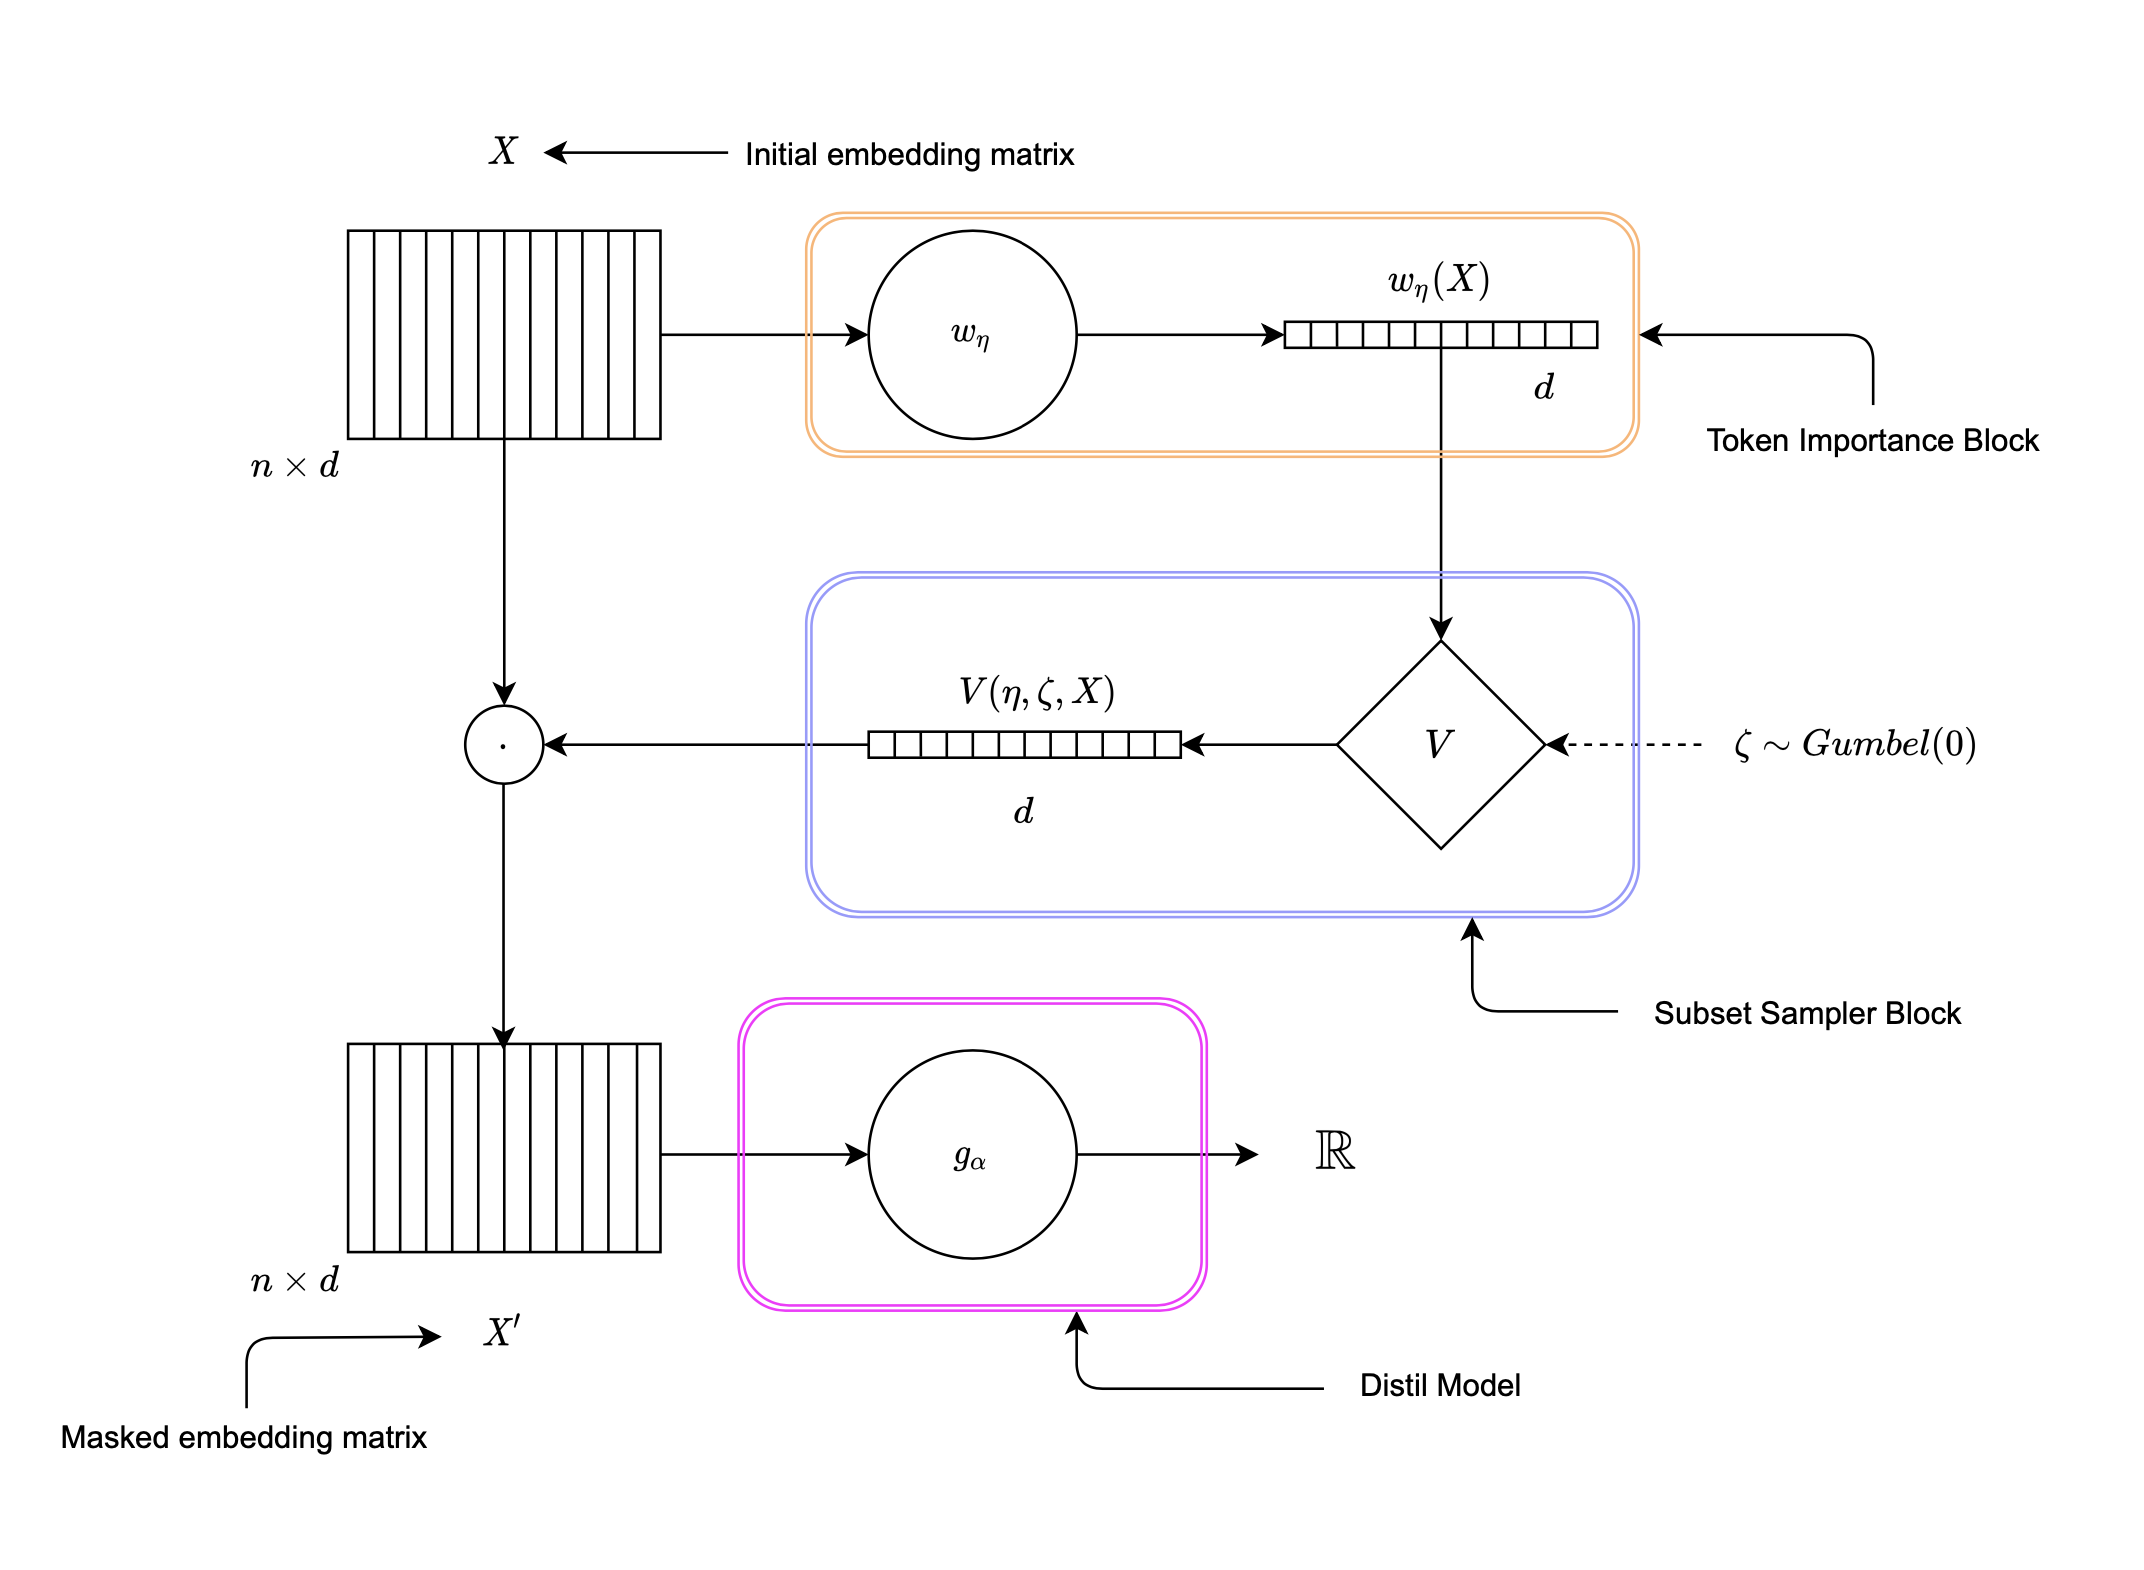

4. Some info about parameters:
 - ``n_important`` - number of important tokens;
 - ``temperature`` - initial temperature used in gumbel softmax trick;
 - ``train_device`` - device used for training;
 - ``inference_device`` - device used for inference;
 - ``verbose`` - verbose mode;
 - ``binning_mode`` - for training we use batch sampling by the length of sequence. So, batch formed only by the sequences from the respect bin. This parameter used for method of automatic binning border choosing. There are two of them: ``'linear'`` (min-max binning, like linspace), ``'hist'`` (histogram binning).
 - ``bins_number`` - number of bins in batch sampling process;
 - ``n_epochs`` - number of epochs of training of the L2X;
 - ``learning_rate`` - learning rate of L2X model;
 - ``patience`` - number of epoches before learning rate decreasing (``torch.optim.lr_scheduler.ReduceLROnPlateu``);
 - ``extreme_patience`` - number of epoches before early stopping by the validation dataset;
 - ``train_batch_size`` - size of batch for training process;
 - ``valid_batch_size`` - size of batch for validation process;
 - ``temp_anneal_factor`` - annealing factor for temperature. The temperature will be multiplied by this coefficient every epoch.
 - ``importance_sampler`` - specifices method of sampling importance (there are two of them ``'gumbeltopk'`` - method from the original paper, ``'softsub'`` - another method);
 - `max_vocab_length` - maximum lenght of vocabular (vocabular build up from ``max_vocab_length`` the most frequent tokens). If ``max_vocab_length`` is ``-1`` then include all in train set.
 - ``embedder`` - embedding dictionary or path to fasttext/dict of embeddings.
 
5. Some links for more info about L2X:
    1. [Gumbel Softmax Trick](https://arxiv.org/abs/1611.00712)
    2. [L2X Original Paper](https://arxiv.org/abs/1802.07814)
    3. [SoftSub Paper](https://arxiv.org/abs/1901.10517)

In [29]:
l2x = L2XTextExplainer(automl, train_device='cuda:1',
                       inference_device='cuda:1',
                       embedding_dim=300,
                       gamma=0.1, temperature=2, temp_anneal_factor=0.95,
                       n_epochs=200, importance_sampler='gumbeltopk',
                       n_important=20, verbose=False, patience=25,
                       extreme_patience=30, trainable_embeds=True)

l2x.fit(train_data, valid_data, cols_to_explain='Review')

test: 100%|██████████| 313/313 [00:47<00:00,  6.65it/s]


In [30]:
expl_train = l2x['Review'].explain_instances(train_data)

In [31]:
expl_valid = l2x['Review'].explain_instances(valid_data)

### Examples

In [32]:
expl_valid[66].visualize_in_notebook()

Text
 
 
 <START> lot exploder lost about 3 of this beer down the drain as foam whats left is a cloudy medium brown color with floaties plenty of head obviously which dissipates quickly aroma is tons of malt and dark fruit the flavor is again very fruity with bready malt and caramel notes a bit of roast malt no hint of spices anywhere full bodied with plenty of silky crispness <PAD>

In [33]:
expl_valid[55].visualize_in_notebook()

Text
 
 
 <START> whoa is right with this one this is a big brew in my opinion hence its name pours a thick creamy head and has a dark brown color with hints of amber the taste ha thick hops in here think of biting into a big juicy fruit terrapin comes out strong with this seasonal taste of alcohol is well hidden but will creap up on you in a hurry i have found this most of the year for some reason i guess they distributed alot of it in the atlanta area <PAD>

In [34]:
expl_valid[77].visualize_in_notebook()

Text
 
 
 <START> the beer pours an opaque light copper capped by a minimal off white head there s very little retention despite a robust pour into the glass the nose is simply divine i feel like i just pulled a freshly baked pumpkin pie out of the oven aromas of gram cracker and butterscotch covered shortbread mix with sweet potato and canned <UNK> pumpkin puree coconut cinnamon and a hint of citrus add a twist of the exotic liquid pumpkin pie is the best way to describe the flavour a fine pte sucre crust with a rich pumpkin filling spiced with cinnamon and allspice this really is devilishly good everything i found lacking in previous pumpkin beers this makes up for smooth creamy macadamia nuttiness adds another dimension hops are nearly <UNK> simple there for balance similarly absent is the taste of alcohol despite the whopping percentage only int he very finish does it pop up like a <UNK> child the medium body and medium low level of carbonation make for a surprisingly easy drinking beer dangerous this is the best pumpkin beer i ve ever had hands down <PAD>

In [35]:
expl_valid[88].visualize_in_notebook()

Text
 
 
 <START> og 5 p sg 046 1 abv pours out to a clear very pale golden forming a soapy white head with decent retention and good lacing carbonation is moderate aroma of weak floral hops with a touch of freesia corn and a light dryness mouthfeel is average watery with a light body and clean finish taste is predominated by corn with hardly any perceptable hop flavor or bitterness cleanly fermented with a crisp finish this is a very simple beer and only a step above budweiser if you need to transition someone from macro domestic swill to an average pale ale then this would be the one comparable to the lightest tap at any new brewpub easy to drink but then again why would i want to <PAD>

In [36]:
expl_valid[121].visualize_in_notebook()

Text
 
 
 <START> a blend of stout and bock cool hopefully better than a blend of wheat and <UNK> a inside joke for anyone who has worked as a grain handler not a good thing i know some beer gods frown on the whole black tan thing this is my first so in i dive in with my usual open <UNK> looked like watered down cola head fizzled fast not a good sign as it definitely was n t too cold hey decent lacing it s really trying to give me that chocolate coffee stout smell here but it s muted some slight coffe toffee taste initially with a hint of hop bitterness maybe even a little nutty but it seems to be out of balance hence the blending thing i guess very very thin and watery given it s parent ingredients got this in a beers of the world pack so bonus would certainly taste fairy exotic to a macro lager person but i wo n t be <UNK> my <UNK> account to get some more out of <UNK> usa anytime soon <PAD>

In [37]:
expl_valid[888].visualize_in_notebook()

Text
 
 
 <START> beer is a dark dark color with just the slightest hints of ruby at the edges and a coffee colored head beautiful to look at and almost as nice to drink the smell is coffee cocoa and just a hint of caramel or toffee with an underlying alcohol character and honey sweetness taste is very similar to the smell with the coffee and cocoa taking center stage and the alcohol almost overpowering the toffee and caramel notes luckily the sweetness helps to balance that out mouthfeel is good nice and thick with just a hint of stickiness the drinkability is n t the best i was actually surprised that this did n t have the highest abv of the beers i had at dragonmead that being said it was a perfectly enjoyable beer and i d jump at the chance to have another <PAD>

In [38]:
expl_valid[999].visualize_in_notebook()

Text
 
 
 <START> ten fidy another thanks to <UNK> for the trade bod 17 pours a rusted mahoghany and settles jet metal black a fingers worth of burnt caramel head sits for a short while the edges leave very little light to pass through spotty lacing clings throughout the nose brings a lot of milk chocolate that has a bittering end to it roasted malts and a presence of alcohol are also noted the taste is interesting the roasty malts bloom but an annoying metallic taste lingers there is a light hop presence as it warms the flavors intensify the mouthfeel is very full bodied and sits like an <UNK> creamy feel with good carbonation overall pretty good impy stout but that metal taste was a bit off putting i would like to try this fresh to see if there is a difference <PAD>

In [39]:
expl_valid[333].visualize_in_notebook()

Text
 
 
 <START> this is a wow witbier cloudy yellow with tendencies toward something darker more orange the head is a little flat though there s a good flowery perfume aroma soft citrus light coriander come up front wiht a good dry wheat in the finish this is a little heftier than the supposed style stalwart hoegaarden but the soft almost creamy mouthfeel makes this a surprisingly satisfying beer without being heavy tasty beer <PAD>

In [40]:
expl_valid[111].visualize_in_notebook()

Text
 
 
 <START> dark black with creamy tan head that leaves great retention and foamy lace the smell is roasty with burnt sugar edges dark chocolate coffee and smoke the taste is ashy too much black patent perhaps others enjoy this but there is a charcoal burnt taste that is a bit much for me smoky bitter chocolate and roasted coffee quite roasty and ashy tasting strong with alcohol peeking through overall an average stout <PAD>

In [41]:
expl_valid[100].visualize_in_notebook()

Text
 
 
 <START> reviewing the oaked arrogant bastard ale from stone brewing company a hearty thank you to beeradvocate user funhog for hooking me up with this one score appearance pours a dark red brown color with plenty of opaque ish ruby highlights with three fingers of cream colored head excellent lacing and the head really stick around if not apparent by the photo proprietary 5 smell piney citrusy hops and oak wood up front creamy chocolate a little caramel and figs oranges tangerines and malts 5 taste very sweet caramel and citrus hoppy with toasted maltiness slightly bitter finish 5 mouthfeel medium bodied oily and cream low carbonation complements the viscosity well dry bitter finish 5 overall a very solid brew but the original version arrogant bastard ale is better in my opinion double bastard is even better this beer is absolutely worth trying but a six pack seems a bit much on quantity for me i guess i have some extras for future ba trades recommendation i can certainly recommend this one to both beer geeks and casual beer drinkers as the flavors are pretty solid and not overwhelming but the oaking does not seem to add enough additional character flavor to justify the steep price jump i would most recommend this beer as one to add to a mix a six pairings hamburger cost 99 for a six pack <PAD>

In [42]:
expl_valid[1021].visualize_in_notebook()

Text
 
 
 <START> 750ml bottle into a tulip huge thanks to kevin for sharing this ancient oddity a muddy magenta brown body with a handful of off white bubbles meh s old musty oaky dirty vaguely reminiscent of tequila in a very weird way i do n t know that i ve ever smelled a more basementy beer and i kind of like it in a masochistic way t like liquid dementia so so old and yet still tasty some moderate sourness and acidic fruitiness is still there to provide at least a hint at what this beer used to be i dig it m smooth soft amazingly delicate o this was n t exactly delicious but it was a great experience i wish i d gotten the chance to taste this five years ago cheers <PAD>

In [43]:
expl_valid[9999].visualize_in_notebook()

Text
 
 
 <START> the apperance was an amber dark yellow color with not much head it did however have stuff floating in it i m not certain if that was of the fault of the manufacturer or the fault of myself for trusting my friends around my <UNK> drink any who the smell was bellow average although not always clearly present the taste was a sweet sour mix with a main taste of bitterness mouthfeel was smooth esque drinkability was average but seeing as i m a big time <UNK> and seeing as it s what my friends have i will most likely be having another very soon <PAD>

In [44]:
expl_valid[7676].visualize_in_notebook()

Text
 
 
 <START> pale gold with a thin film around the edge some lacing looks very flat and insipid no carbonation i do n t hold out much hope very unpleasant sticky rice nose lots of nothingness as well sweet with a very light sickly note but do n t get me wrong it s incredibly bland blech thin but fortunately not overly sweet on the palate quite clean and dry with a light lingering bitterness mouthfeel is quite crisp which is a blessing no it s not great but i was expecting a lot lot worse it s really not that bad when you get down to it it s not amazing but it s pretty clean and light i guess i m just pleased it does n t have the sweet sickly character promised on the nose <PAD>

In [45]:
expl_valid[6767].visualize_in_notebook()

Text
 
 
 <START> i was actually a little surprised by this one surprised it was not vile pours a clear gold color with a thin white head no real lacing to speak of and the head was short lived the aroma is lightly sweet which was another surprise light bodied with a barely average hops flavor the finish is a little sweet and a little fruity this is n t a beer i would seek out again but i would drink it in korea over a bud <PAD>

In [46]:
expl_valid[3131].visualize_in_notebook()

Text
 
 
 <START> pours a clear deep red brown with a big white head malty sweet no major flavors stand out though it is slightly toasty hops are clean and mellow they only come in near the end and help to balance the beer this is a solid simple brown it s so great to finally see organic beer in the store <PAD>